In [5]:
suppressPackageStartupMessages({
    library(tidyr)
    library(patchwork)
    library(Seurat)
    library(conos)  
    library(dplyr)
    library(ggplot2)
    library(infercnv)
})

In [1]:
tumor_immune_combined = readRDS(glue::glue(
        '/home/hsarkar/Projects/neuroblastoma_analysis/',
        'results/seurat/mouse_nb_adrenal_8_samples_seurat_cc_regressed.rds'
    ))

In [4]:
tumor_immune_combined@assays$RNA@counts[1:2,1:2]

2 x 2 sparse Matrix of class "dgCMatrix"
     het1_tumor_AAACCCAAGCTTTCCC-1 het1_tumor_AAACCCAAGGCGTTAG-1
MYCN                             1                             6
XKR4                             .                             1

In [7]:
rownames(tumor_immune_combined)[grepl('MYCN', rownames(tumor_immune_combined))]

[1] "MYCN"

In [11]:
gene_pos = data.table::fread(
    glue::glue(
        '/home/hsarkar/Projects/neuroblastoma_analysis/',
        'infercnv_files/mycn_gene_pos.txt'
    ),
    sep='\t'
) 

In [24]:
gene_pos %>% head(2)

V1,V2,V3,V4
<chr>,<chr>,<int>,<int>
mycn___MYCN,mycn___2_mycn,1,6444
GRCm38_Xkr4,GRCm38_1,3205901,3671498


In [25]:
gene_pos$V1 = lapply(gene_pos$V1, FUN = function(x) 
    {stringr::str_match(x, '(.*)_(.*)')[, -1][[2]]}
) %>% unlist %>% toupper 

gene_pos$V2 = lapply(gene_pos$V2, FUN = function(x) 
    {stringr::str_match(x, '(.*)_(.*)')[, -1][[2]]}
) %>% unlist 

In [53]:
gene_pos %>% dim

[1] 31374     4

In [55]:
gene_pos %>% arrange(V1) %>% filter(duplicated(V1) == FALSE) %>% dim

[1] 31373     4

In [65]:
gene_pos %>% head

V1,V2,V3,V4
<chr>,<chr>,<int>,<int>
MYCN,mycn,1,6444
XKR4,1,3205901,3671498
GM1992,1,3466587,3513553
GM37381,1,3905739,3986215
RP1,1,3999557,4409241
SOX17,1,4490931,4497354


In [56]:
data.table::fwrite(
    gene_pos %>% filter(duplicated(V1) == FALSE),
    glue::glue(
        '/home/hsarkar/Projects/neuroblastoma_analysis/',
        'infercnv_files/mycn_gene_pos_mod.txt'
    ),
    col.names = FALSE,
    sep='\t'
)

In [33]:
count_matrix = as.matrix(tumor_immune_combined@assays$RNA@counts)

In [35]:
count_matrix[1:2,1:2]

,het1_tumor_AAACCCAAGCTTTCCC-1,het1_tumor_AAACCCAAGGCGTTAG-1
MYCN,1,6
XKR4,0,1


In [111]:
annot_df = tumor_immune_combined$clusters %>% 
    data.frame %>%
    tibble::rownames_to_column(var='cell') %>%
    magrittr::set_colnames(c('cell','cell_type')) %>%
    filter(!is.na(cell_type))

annot_df %>%
    data.table::fwrite(
        glue::glue(
            '/home/hsarkar/Projects/neuroblastoma_analysis/',
            'infercnv_files/',
            'mouse_nb_adrenal_8_samples_seurat_cc_regressed_annot.txt'
        ),
        col.names = FALSE,
        sep='\t'
    )

In [114]:
annot_df %>% dim

[1] 60744     2

In [115]:
count_matrix = count_matrix[, annot_df$cell ]

In [117]:
annot_df$cell_type %>% unique 

[1] Sympathoblast 3             Chromaffin                 
 [3] Endothelial cells           Sympathoblast 2            
 [5] Sympathoblast 1             Sympathoblast 4            
 [7] Immature ADRN               T cells                    
 [9] Mesenchymal 1               Myeloid                    
[11] B cells                     Sympathoblast 5            
[13] Mesenchymal 2               Pericytes                  
[15] DC                          Neutrophils                
[17] Mesenchymal 3               Transitioning adrenal cells
[19] Adrenocortical primordial   SCP                        
[21] Bridge                      VSMC                       
[23] Mesenchymal 4              
23 Levels: Adrenocortical primordial B cells Bridge Chromaffin ... VSMC

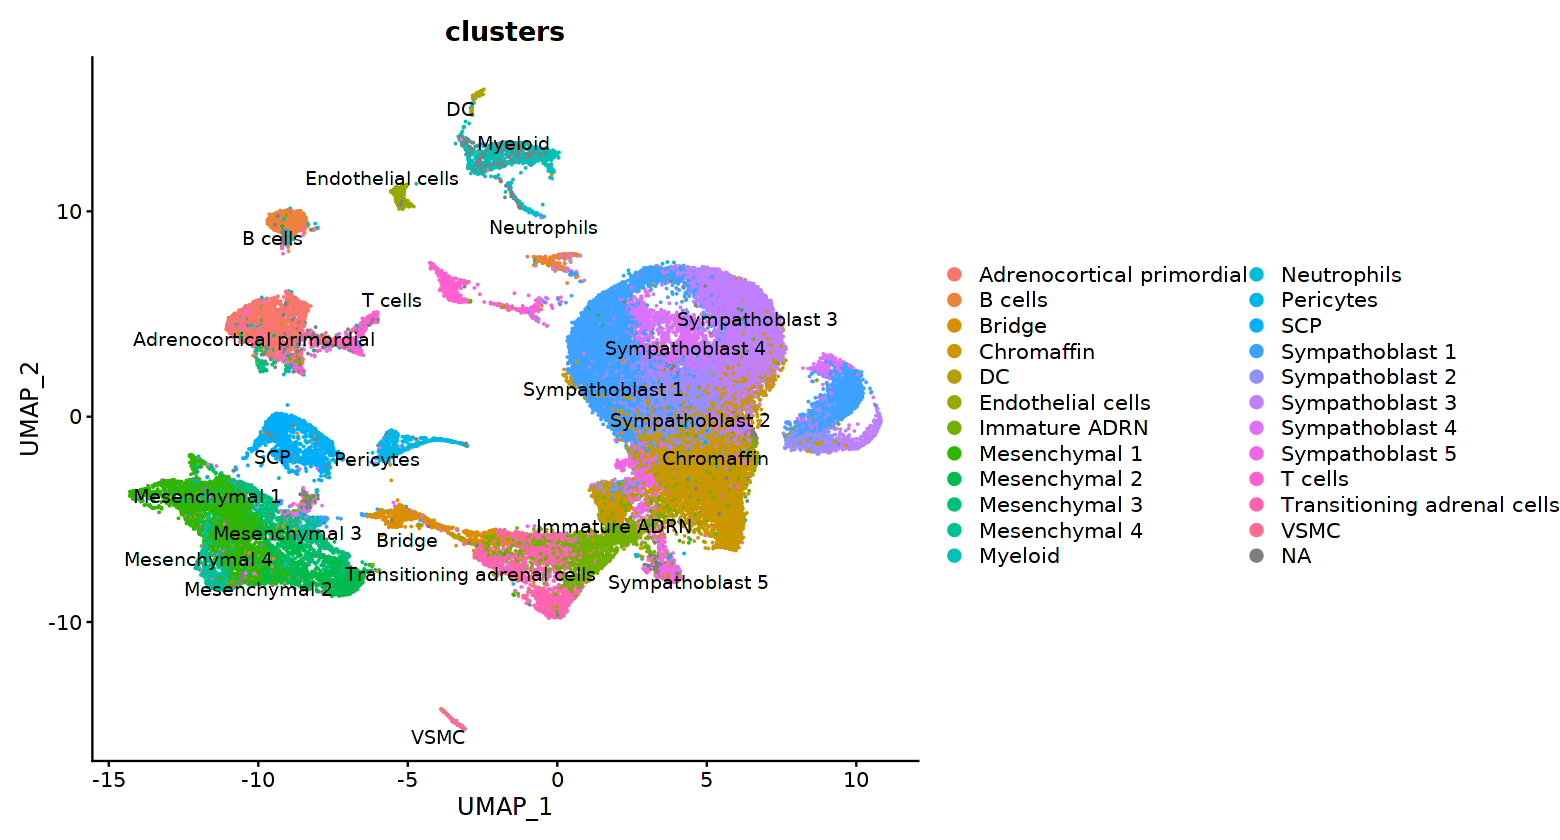

In [44]:
options(repr.plot.height=7, repr.plot.width=13, res=150 ) 
DimPlot(tumor_immune_combined, 
        reduction = "umap", 
        group.by = "clusters",
        label = TRUE, repel = TRUE)

In [118]:
count_matrix %>% dim

[1] 21457 60744

In [119]:
infercnv_obj = CreateInfercnvObject(
    raw_counts_matrix=count_matrix,
    annotations_file= glue::glue(
            '/home/hsarkar/Projects/neuroblastoma_analysis/',
            'infercnv_files/',
            'mouse_nb_adrenal_8_samples_seurat_cc_regressed_annot.txt'
        ),
    delim="\t",
    gene_order_file = glue::glue(
            '/home/hsarkar/Projects/neuroblastoma_analysis/',
            'infercnv_files/mycn_gene_pos_mod.txt'
    ),
    ref_group_names = c(
        'Adrenocortical primordial',
        'B cells',
        'T cells',
        'Endothelial cells',
        'Mesenchymal 1',
        'Mesenchymal 2',
        'Mesenchymal 3',
        'Mesenchymal 4',
        'Pericytes',
        'Myeloid'
    )
) 


INFO [2022-01-02 00:52:38] Parsing gene order file: /home/hsarkar/Projects/neuroblastoma_analysis/infercnv_files/mycn_gene_pos_mod.txt
INFO [2022-01-02 00:52:38] Parsing cell annotations file: /home/hsarkar/Projects/neuroblastoma_analysis/infercnv_files/mouse_nb_adrenal_8_samples_seurat_cc_regressed_annot.txt
INFO [2022-01-02 00:52:38] ::order_reduce:Start.
INFO [2022-01-02 00:52:44] .order_reduce(): expr and order match.
INFO [2022-01-02 00:52:50] ::process_data:order_reduce:Reduction from positional data, new dimensions (r,c) = 21457,60744 Total=367197784 Min=0 Max=4405.
INFO [2022-01-02 00:52:55] num genes removed taking into account provided gene ordering list: 750 = 3.49536281866058% removed.
INFO [2022-01-02 00:52:58] -filtering out cells < 100 or > Inf, removing 0 % of cells
INFO [2022-01-02 00:53:57] validating infercnv_obj


In [122]:
infercnv_obj = infercnv::run(
    infercnv_obj,
    cutoff=0.5, 
    out_dir=tempfile(),
    cluster_by_groups=TRUE, 
    denoise=TRUE,
    num_threads = 30,
    HMM=TRUE
)

INFO [2022-01-02 01:17:30] ::process_data:Start
INFO [2022-01-02 01:17:30] Creating output path /tmp/Rtmp8LviiG/file586a64b27027
INFO [2022-01-02 01:17:30] Checking for saved results.
INFO [2022-01-02 01:17:30] 

	STEP 1: incoming data

INFO [2022-01-02 01:21:46] 

	STEP 02: Removing lowly expressed genes

INFO [2022-01-02 01:21:46] ::above_min_mean_expr_cutoff:Start
INFO [2022-01-02 01:21:52] Removing 18126 genes from matrix as below mean expr threshold: 0.5
INFO [2022-01-02 01:21:56] validating infercnv_obj
INFO [2022-01-02 01:21:56] There are 2581 genes and 60744 cells remaining in the expr matrix.
INFO [2022-01-02 01:22:04] no genes removed due to min cells/gene filter
INFO [2022-01-02 01:23:16] 

	STEP 03: normalization by sequencing depth

INFO [2022-01-02 01:23:16] normalizing counts matrix by depth
INFO [2022-01-02 01:23:21] Computed total sum normalization factor as median libsize: 3227.000000
INFO [2022-01-02 01:23:22] Adding h-spike
INFO [2022-01-02 01:23:22] -hspike modelin

Warning message in type.convert.default(X[[i]], ...):
“'as.is' should be specified by the caller; using TRUE”
Warning message in type.convert.default(X[[i]], ...):
“'as.is' should be specified by the caller; using TRUE”
Warning message in type.convert.default(X[[i]], ...):
“'as.is' should be specified by the caller; using TRUE”
Warning message in type.convert.default(X[[i]], ...):
“'as.is' should be specified by the caller; using TRUE”
Warning message in type.convert.default(X[[i]], ...):
“'as.is' should be specified by the caller; using TRUE”
Warning message in type.convert.default(X[[i]], ...):
“'as.is' should be specified by the caller; using TRUE”
Warning message in type.convert.default(X[[i]], ...):
“'as.is' should be specified by the caller; using TRUE”
Warning message in type.convert.default(X[[i]], ...):
“'as.is' should be specified by the caller; using TRUE”
Warning message in type.convert.default(X[[i]], ...):
“'as.is' should be specified by the caller; using TRUE”
Warning me

INFO [2022-01-02 06:58:16] ::plot_cnv:Start
INFO [2022-01-02 06:58:16] ::plot_cnv:Current data dimensions (r,c)=2581,60744 Total=2464556.06192406 Min=0 Max=0.839545862739003.
INFO [2022-01-02 06:58:17] ::plot_cnv:Depending on the size of the matrix this may take a moment.
INFO [2022-01-02 06:58:22] plot_cnv_observation:Start
INFO [2022-01-02 06:58:22] Observation data size: Cells= 44601 Genes= 2581
INFO [2022-01-02 06:58:37] plot_cnv_observation:Writing observation groupings/color.
INFO [2022-01-02 06:58:37] plot_cnv_observation:Done writing observation groupings/color.
INFO [2022-01-02 06:58:38] plot_cnv_observation:Writing observation heatmap thresholds.
INFO [2022-01-02 06:58:38] plot_cnv_observation:Done writing observation heatmap thresholds.
INFO [2022-01-02 06:59:07] Colors for breaks:  #00008B,#24249B,#4848AB,#6D6DBC,#9191CC,#B6B6DD,#DADAEE,#FFFFFF,#EEDADA,#DDB6B6,#CC9191,#BC6D6D,#AB4848,#9B2424,#8B0000
INFO [2022-01-02 06:59:07] Quantiles of plotted data range: 0,0,0,0,0.83954

In [121]:
tempfile()

[1] "/tmp/Rtmp8LviiG/file586a70e259ba"

In [123]:
saveRDS(
    infercnv_obj,
    glue::glue(
        '/home/hsarkar/Projects/neuroblastoma_analysis/',
        'infercnv_files/',
        'mouse_nb_adrenal_8_samples_seurat_infercnv.rds'
    )
)

In [124]:
options(repr.plot.height=6, repr.plot.width=14, res=150 ) 
plot_cnv(infercnv_obj)

INFO [2022-01-02 09:44:42] ::plot_cnv:Start
INFO [2022-01-02 09:44:42] ::plot_cnv:Current data dimensions (r,c)=2581,60744 Total=157286038.582912 Min=0.631055907755391 Max=6.82466823547949.
INFO [2022-01-02 09:44:43] ::plot_cnv:Depending on the size of the matrix this may take a moment.
INFO [2022-01-02 09:44:48] plot_cnv(): auto thresholding at: (0.888578 , 1.117874)
INFO [2022-01-02 09:44:53] plot_cnv_observation:Start
INFO [2022-01-02 09:44:53] Observation data size: Cells= 44601 Genes= 2581
INFO [2022-01-02 09:45:08] plot_cnv_observation:Writing observation groupings/color.
INFO [2022-01-02 09:45:08] plot_cnv_observation:Done writing observation groupings/color.
INFO [2022-01-02 09:45:10] plot_cnv_observation:Writing observation heatmap thresholds.
INFO [2022-01-02 09:45:10] plot_cnv_observation:Done writing observation heatmap thresholds.
INFO [2022-01-02 09:45:39] Colors for breaks:  #00008B,#24249B,#4848AB,#6D6DBC,#9191CC,#B6B6DD,#DADAEE,#FFFFFF,#EEDADA,#DDB6B6,#CC9191,#BC6D6D,#

$cluster_by_groups
[1] TRUE

$k_obs_groups
[1] 3

$contig_cex
[1] 1

$x.center
[1] 1.003226

$x.range
[1] 0.8885777 1.1178743

$hclust_method
[1] "ward.D"

$color_safe_pal
[1] FALSE

$output_format
[1] "png"

$png_res
[1] 300

$dynamic_resize
[1] 0